# Building an xG Model from Scratch
### Columbus Crew Dashboard — Portfolio Project

---

**What this notebook does:**
1. Explains the math behind Expected Goals (xG)
2. Loads real shot data from StatsBomb open data
3. Engineers features (distance, angle, technique)
4. Trains a logistic regression model
5. Evaluates it with proper metrics
6. Exports the model for use in the dashboard

> **Why logistic regression?** It's the industry standard starting point for xG modeling. It's interpretable (you can explain *why* each shot has its probability), fast to train, and legitimate — StatsBomb themselves use logistic regression as a baseline.

## Part 1: The Math (Read This Before Running Any Code)

### What is a probability model?

We want to answer: **given a shot, what's the probability it becomes a goal?**

We can't use regular linear regression for this because probabilities must stay between 0 and 1 — linear regression has no such constraint. That's where **logistic regression** comes in.

### The Sigmoid Function

Logistic regression applies a **sigmoid function** to a linear equation:

$$P(\text{goal}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ...)}}$$

Breaking this down:
- $x_1, x_2, ...$ are your **features** (distance, angle, technique)
- $\beta_0, \beta_1, \beta_2, ...$ are **coefficients** the model learns from data
- The sigmoid function squishes any number into a value between 0 and 1
- The output is a **probability** — e.g. 0.73 means 73% chance of a goal

### How does the model "learn"?

Training means finding the $\beta$ values that make the model's predictions match reality as closely as possible. It does this by minimizing **log loss** (also called binary cross-entropy):

$$\text{Log Loss} = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{p}_i) + (1 - y_i) \log(1 - \hat{p}_i) \right]$$

Where:
- $y_i = 1$ if the shot was a goal, $0$ if not
- $\hat{p}_i$ is the model's predicted probability
- The model adjusts $\beta$ values to minimize this loss

**Intuition:** If the model says a shot has a 90% chance of being a goal and it actually IS a goal, log loss is low (good). If the model says 90% chance and it's NOT a goal, log loss is high (bad). The model learns to be well-calibrated.

### Key features for xG

| Feature | Why it matters |
|---|---|
| Distance to goal | Closer shots score more often |
| Shot angle | Wider angles are harder |
| Technique (header vs foot) | Headers convert at ~60% the rate of foot shots |
| Under pressure | Pressured shots convert less |
| From open play vs set piece | Set piece shots are often lower quality |

---

## Part 2: Setup & Data Loading

In [ ]:
# Install dependencies if needed
# Run this cell once, then comment it out
# !pip install statsbombpy scikit-learn pandas numpy matplotlib seaborn mplsoccer joblib

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import json
import os
import joblib

from statsbombpy import sb
from mplsoccer import Pitch

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, log_loss, brier_score_loss,
    classification_report, RocCurveDisplay
)
from sklearn.calibration import CalibrationDisplay
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.3f}'.format)

# Crew colors
CREW_GOLD  = '#F5C518'
CREW_BLACK = '#14130F'

print('All imports successful!')

All imports successful!


In [10]:
# ── Load StatsBomb open data ──────────────────────────────
# StatsBomb provides free event data for select competitions.
# We'll use multiple competitions to maximize our training data.
# More data = better model.

print('Available competitions:')
comps = sb.competitions()
print(comps[['competition_name', 'season_name', 'competition_id', 'season_id']].to_string())

Available competitions:
           competition_name season_name  competition_id  season_id
0             1. Bundesliga   2023/2024               9        281
1             1. Bundesliga   2015/2016               9         27
2    African Cup of Nations        2023            1267        107
3          Champions League   2018/2019              16          4
4          Champions League   2017/2018              16          1
5          Champions League   2016/2017              16          2
6          Champions League   2015/2016              16         27
7          Champions League   2014/2015              16         26
8          Champions League   2013/2014              16         25
9          Champions League   2012/2013              16         24
10         Champions League   2011/2012              16         23
11         Champions League   2010/2011              16         22
12         Champions League   2009/2010              16         21
13         Champions League   2008/200

In [11]:
# We'll pull shots from multiple competitions for a robust training set.
# These are all freely available from StatsBomb.
COMPETITIONS = [
    {'competition_id': 2,   'season_id': 27},   # Premier League 2015/16
    {'competition_id': 11,  'season_id': 1},    # La Liga 2005/06
    {'competition_id': 49,  'season_id': 3},    # Women's World Cup 2019
    {'competition_id': 72,  'season_id': 30},   # NWSL 2018
]

all_shots = []

for comp in COMPETITIONS:
    cid, sid = comp['competition_id'], comp['season_id']
    try:
        matches = sb.matches(competition_id=cid, season_id=sid)
        print(f'Competition {cid}/{sid}: {len(matches)} matches')

        for match_id in matches['match_id']:
            events = sb.events(match_id=match_id)
            shots  = events[events['type'] == 'Shot'].copy()
            if len(shots) > 0:
                shots['competition_id'] = cid
                shots['season_id']      = sid
                all_shots.append(shots)

    except Exception as e:
        print(f'  Skipping {cid}/{sid}: {e}')

shots_raw = pd.concat(all_shots, ignore_index=True)
print(f'\nTotal shots loaded: {len(shots_raw):,}')
print(f'Goal rate: {(shots_raw["shot_outcome"] == "Goal").mean():.1%}')

  Skipping 2/27: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Competition 11/1: 36 matches
  Skipping 11/1: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Competition 49/3: 36 matches
  Skipping 49/3: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Competition 72/30: 52 matches
  Skipping 72/30: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

Total shots loaded: 254
Goal rate: 14.2%


## Part 3: Feature Engineering

This is where domain knowledge meets data science. We need to transform raw shot coordinates into meaningful predictors.

**StatsBomb pitch coordinates:**
- The pitch is 120 x 80 units
- Goal center is at (120, 40)
- (0, 0) is the bottom-left corner

In [13]:
def engineer_features(df):
    """
    Transform raw StatsBomb shot data into model features.
    Returns a clean DataFrame ready for training.
    """
    shots = df.copy()

    # ── Extract shot coordinates ──────────────────────────
    shots['x'] = shots['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else np.nan)
    shots['y'] = shots['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else np.nan)

    # ── Goal center (StatsBomb coordinates) ──────────────
    GOAL_X = 120
    GOAL_Y = 40

    # Feature 1: Distance to goal center
    # Euclidean distance — closer shots are harder to save
    shots['distance'] = np.sqrt(
        (shots['x'] - GOAL_X) ** 2 +
        (shots['y'] - GOAL_Y) ** 2
    )

    # Feature 2: Shot angle (in radians, then converted to degrees)
    # The angle between the shot location and the two goalposts
    # A wider angle = better chance = higher xG
    GOAL_POST_Y1 = 36  # left post
    GOAL_POST_Y2 = 44  # right post

    # Vector from shot location to each post
    a = np.sqrt((shots['x'] - GOAL_X)**2 + (shots['y'] - GOAL_POST_Y1)**2)
    b = np.sqrt((shots['x'] - GOAL_X)**2 + (shots['y'] - GOAL_POST_Y2)**2)
    c = np.abs(GOAL_POST_Y2 - GOAL_POST_Y1)  # width of goal = 8 units

    # Law of cosines to find the angle
    cos_angle = (a**2 + b**2 - c**2) / (2 * a * b)
    cos_angle = np.clip(cos_angle, -1, 1)  # prevent numerical errors
    shots['angle_deg'] = np.degrees(np.arccos(cos_angle))

    # Feature 3: Is header?
    shots['is_header'] = (shots['shot_body_part'] == 'Head').astype(int)

    # Feature 4: Under pressure?
    shots['under_pressure'] = shots['under_pressure'].fillna(False).astype(int)

    # Feature 5: Play pattern (open play = 1, set piece = 0)
    open_play_patterns = ['Regular Play', 'From Goal Kick', 'From Keeper']
    shots['is_open_play'] = shots['play_pattern'].isin(open_play_patterns).astype(int)

    # Feature 6: Distance squared (non-linear relationship — drop-off is steep)
    shots['distance_sq'] = shots['distance'] ** 2

    # ── Target variable ───────────────────────────────────
    shots['is_goal'] = (shots['shot_outcome'] == 'Goal').astype(int)

    # ── Remove own goals (not predictable the same way) ───
    if 'shot_type' in shots.columns:
        shots = shots[shots['shot_type'] != 'Own Goal']

    # ── Drop rows with missing key features ───────────────
    features = ['distance', 'angle_deg', 'is_header', 'under_pressure',
                'is_open_play', 'distance_sq', 'is_goal']
    shots = shots.dropna(subset=['x', 'y', 'distance', 'angle_deg'])

    return shots[features + ['x', 'y', 'shot_outcome', 'shot_body_part', 'play_pattern']]


shots_featured = engineer_features(shots_raw)

print(f'Shots after feature engineering: {len(shots_featured):,}')
print(f'Goal rate: {shots_featured["is_goal"].mean():.1%}')
print()
shots_featured.describe()

Shots after feature engineering: 254
Goal rate: 14.2%



,distance,angle_deg,is_header,under_pressure,is_open_play,distance_sq,is_goal,x,y
count,254.000,254.000,254.000,254.000,254.000,254.000,254.000,254.000,254.000
mean,17.701,28.239,0.157,0.142,0.449,387.237,0.142,104.807,39.422
std,8.614,18.170,0.365,0.349,0.498,366.288,0.349,8.590,9.104
min,2.828,3.452,0.000,0.000,0.000,8.000,0.000,76.000,9.700
25%,10.739,16.037,0.000,0.000,0.000,115.318,0.000,99.025,33.825
50%,16.706,22.737,0.000,0.000,0.000,279.090,0.000,106.700,38.700
75%,23.421,36.088,0.000,0.000,1.000,548.605,0.000,111.700,45.700
max,50.606,123.343,1.000,1.000,1.000,2561.000,1.000,119.600,65.000


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jakef\\Crew2025xG\\notebooks\\assets\\feature_distributions.png'

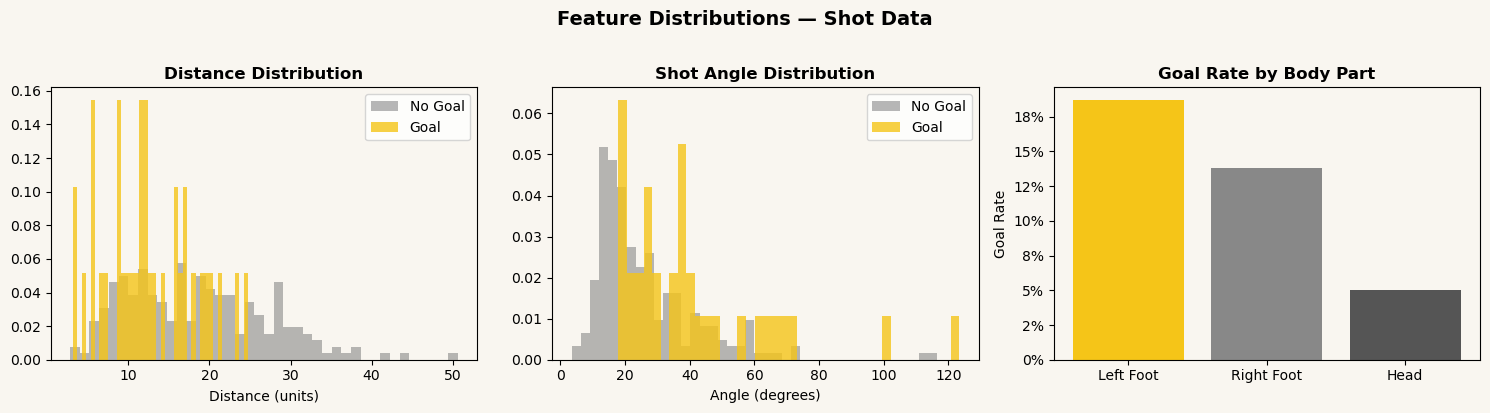

In [14]:
# ── Visualize key feature distributions ──────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.patch.set_facecolor('#F9F6F0')

for ax in axes:
    ax.set_facecolor('#F9F6F0')

# Distance distribution by outcome
goals     = shots_featured[shots_featured['is_goal'] == 1]
non_goals = shots_featured[shots_featured['is_goal'] == 0]

axes[0].hist(non_goals['distance'], bins=40, alpha=0.6, color='#888', label='No Goal', density=True)
axes[0].hist(goals['distance'],     bins=40, alpha=0.8, color=CREW_GOLD, label='Goal',    density=True)
axes[0].set_title('Distance Distribution', fontweight='bold')
axes[0].set_xlabel('Distance (units)')
axes[0].legend()

# Angle distribution by outcome
axes[1].hist(non_goals['angle_deg'], bins=40, alpha=0.6, color='#888', label='No Goal', density=True)
axes[1].hist(goals['angle_deg'],     bins=40, alpha=0.8, color=CREW_GOLD, label='Goal',    density=True)
axes[1].set_title('Shot Angle Distribution', fontweight='bold')
axes[1].set_xlabel('Angle (degrees)')
axes[1].legend()

# Goal rate by body part
body_part_rates = shots_featured.groupby('shot_body_part')['is_goal'].mean().sort_values(ascending=False)
bars = axes[2].bar(body_part_rates.index, body_part_rates.values, color=[CREW_GOLD, '#888', '#555', '#333'])
axes[2].set_title('Goal Rate by Body Part', fontweight='bold')
axes[2].set_ylabel('Goal Rate')
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.suptitle('Feature Distributions — Shot Data', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('assets/feature_distributions.png', dpi=150, bbox_inches='tight', facecolor='#F9F6F0')
plt.show()
print('Insight: Goals cluster at shorter distances and wider angles — exactly what we expect.')

## Part 4: Train the Model

### Train/Test Split — Why It Matters

We split data into **training** (80%) and **testing** (20%) sets.

- **Training set**: The model sees these shots and learns from them
- **Test set**: The model has never seen these — we use them to measure real performance

Without this split, you'd be measuring how well the model memorized your data, not how well it generalizes. A model that only works on data it's already seen is useless in practice.

### Feature Scaling

Logistic regression is sensitive to feature scale. Distance ranges from 0–60, angle from 0–90. We use `StandardScaler` to normalize them to a common scale (mean=0, std=1) so no single feature dominates just because its numbers are bigger.

In [ ]:
FEATURES = ['distance', 'angle_deg', 'is_header', 'under_pressure', 'is_open_play', 'distance_sq']
TARGET   = 'is_goal'

X = shots_featured[FEATURES]
y = shots_featured[TARGET]

# 80/20 split, stratified so goal rate is preserved in both halves
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,       # makes results reproducible
    stratify=y             # preserves ~10% goal rate in both splits
)

print(f'Training shots : {len(X_train):,}  (Goal rate: {y_train.mean():.1%})')
print(f'Test shots     : {len(X_test):,}   (Goal rate: {y_test.mean():.1%})')

In [ ]:
# ── Build pipeline: scale then fit ───────────────────────
# A Pipeline chains steps so scaling and fitting happen together.
# This prevents data leakage (scaler learns ONLY from training data).

xg_model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        C=1.0,              # regularization strength (1.0 = default, balanced)
        max_iter=1000,      # iterations to converge
        random_state=42
    ))
])

xg_model.fit(X_train, y_train)

print('Model trained!')

# ── Inspect coefficients ──────────────────────────────────
# This is the interpretability advantage of logistic regression.
# Negative = reduces goal probability, Positive = increases it.

coef_df = pd.DataFrame({
    'Feature':     FEATURES,
    'Coefficient': xg_model.named_steps['logreg'].coef_[0]
}).sort_values('Coefficient')

print('\nModel Coefficients (scaled):')
print(coef_df.to_string(index=False))
print('\nInterpretation:')
print('  Negative = REDUCES goal probability (e.g. distance hurts)')
print('  Positive = INCREASES goal probability (e.g. wider angle helps)')

In [ ]:
# Visualize coefficients
fig, ax = plt.subplots(figsize=(9, 4))
fig.patch.set_facecolor('#F9F6F0')
ax.set_facecolor('#F9F6F0')

colors = [CREW_GOLD if c > 0 else '#555' for c in coef_df['Coefficient']]
bars   = ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='none')
ax.axvline(0, color='#333', linewidth=0.8)
ax.set_title('Logistic Regression Coefficients\n(Gold = increases xG, Grey = decreases xG)',
             fontweight='bold')
ax.set_xlabel('Coefficient (scaled)')

plt.tight_layout()
plt.savefig('assets/coefficients.png', dpi=150, bbox_inches='tight', facecolor='#F9F6F0')
plt.show()

## Part 5: Evaluate the Model

Three metrics matter for an xG model:

| Metric | What it measures | Good value |
|---|---|---|
| **ROC-AUC** | How well the model ranks shots by quality | > 0.75 |
| **Log Loss** | How well-calibrated the probabilities are | < 0.30 |
| **Brier Score** | Mean squared error of probabilities | < 0.09 |

**Why not accuracy?** Because ~90% of shots don't result in goals. A model that always predicts 'no goal' would be 90% accurate — but completely useless. AUC and log loss tell you whether the *probabilities* are meaningful.

In [ ]:
# ── Generate predictions ──────────────────────────────────
y_proba = xg_model.predict_proba(X_test)[:, 1]  # probability of goal

auc    = roc_auc_score(y_test, y_proba)
logloss = log_loss(y_test, y_proba)
brier  = brier_score_loss(y_test, y_proba)

print('=' * 40)
print('  MODEL EVALUATION (Test Set)')
print('=' * 40)
print(f'  ROC-AUC    : {auc:.4f}   (target > 0.75)')
print(f'  Log Loss   : {logloss:.4f}   (target < 0.30)')
print(f'  Brier Score: {brier:.4f}   (target < 0.09)')
print('=' * 40)

if auc > 0.75:
    print('\n  AUC looks good! The model ranks shot quality well.')
else:
    print('\n  AUC is low — consider adding more features or training data.')

In [ ]:
# ── ROC Curve & Calibration Plot ──────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig.patch.set_facecolor('#F9F6F0')
for ax in [ax1, ax2]:
    ax.set_facecolor('#F9F6F0')

# ROC Curve
# The closer to the top-left corner, the better the model discriminates
RocCurveDisplay.from_predictions(
    y_test, y_proba,
    name=f'xG Model (AUC={auc:.3f})',
    color=CREW_GOLD,
    ax=ax1
)
ax1.plot([0,1], [0,1], 'k--', alpha=0.4, label='Random classifier')
ax1.set_title('ROC Curve', fontweight='bold')
ax1.legend()

# Calibration Plot
# A well-calibrated model: when it says 20% xG, shots score ~20% of the time
CalibrationDisplay.from_predictions(
    y_test, y_proba,
    n_bins=10,
    name='xG Model',
    color=CREW_GOLD,
    ax=ax2
)
ax2.set_title('Calibration Curve\n(Diagonal = perfectly calibrated)', fontweight='bold')

plt.suptitle('Model Evaluation', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('assets/model_evaluation.png', dpi=150, bbox_inches='tight', facecolor='#F9F6F0')
plt.show()

## Part 6: Apply the Model — Generate xG for Sample Shots

This section demonstrates how to use your trained model to predict xG for any shot, given its coordinates and context. This is what you'd run on Columbus Crew shot data.

In [ ]:
def predict_xg(distance, angle_deg, is_header=0, under_pressure=0, is_open_play=1):
    """
    Predict xG for a single shot.
    Returns a probability between 0 and 1.
    """
    features = pd.DataFrame([{
        'distance':      distance,
        'angle_deg':     angle_deg,
        'is_header':     is_header,
        'under_pressure': under_pressure,
        'is_open_play':  is_open_play,
        'distance_sq':   distance ** 2
    }])
    return xg_model.predict_proba(features)[0][1]


# ── Test with realistic scenarios ─────────────────────────
scenarios = [
    ('Penalty kick',              11,  37, 0, 0, 0),
    ('Close range header',         8,  45, 1, 0, 1),
    ('One-on-one, open play',     14,  40, 0, 0, 1),
    ('Edge of box, under pressure',22,  25, 0, 1, 1),
    ('Long-range effort',          35,  15, 0, 0, 1),
    ('Half-volley from distance',  40,  10, 0, 0, 1),
]

print(f'{"Scenario":<35} {"xG":>6}')
print('-' * 43)
for name, dist, angle, head, press, open_play in scenarios:
    xg = predict_xg(dist, angle, head, press, open_play)
    bar = '█' * int(xg * 30)
    print(f'{name:<35} {xg:>5.3f}  {bar}')

In [ ]:
# ── xG Probability Heatmap ────────────────────────────────
# Visualize xG across the pitch for open-play foot shots
# This is a great visual for your README

GOAL_X, GOAL_Y = 120, 40

# Grid of shot locations in the attacking half
xs = np.linspace(60, 119, 120)
ys = np.linspace(0, 80, 80)
xx, yy = np.meshgrid(xs, ys)

# Calculate distance and angle for each point
dist_grid  = np.sqrt((xx - GOAL_X)**2 + (yy - GOAL_Y)**2)

GOAL_POST_Y1, GOAL_POST_Y2 = 36, 44
a = np.sqrt((xx - GOAL_X)**2 + (yy - GOAL_POST_Y1)**2)
b = np.sqrt((xx - GOAL_X)**2 + (yy - GOAL_POST_Y2)**2)
c = abs(GOAL_POST_Y2 - GOAL_POST_Y1)
cos_angle   = np.clip((a**2 + b**2 - c**2) / (2 * a * b), -1, 1)
angle_grid  = np.degrees(np.arccos(cos_angle))

# Predict xG for each grid point
grid_features = pd.DataFrame({
    'distance':       dist_grid.ravel(),
    'angle_deg':      angle_grid.ravel(),
    'is_header':      np.zeros(dist_grid.size),
    'under_pressure': np.zeros(dist_grid.size),
    'is_open_play':   np.ones(dist_grid.size),
    'distance_sq':    dist_grid.ravel() ** 2
})

xg_grid = xg_model.predict_proba(grid_features)[:, 1].reshape(xx.shape)

# Plot on a pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color=CREW_BLACK, line_color='#555')
fig, ax = pitch.draw(figsize=(13, 8))
fig.set_facecolor(CREW_BLACK)

# Only show attacking half
heatmap = ax.contourf(
    xx, yy, xg_grid,
    levels=20,
    cmap='YlOrRd',
    alpha=0.85,
    vmin=0, vmax=0.5
)

cbar = plt.colorbar(heatmap, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label('xG Probability', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')

ax.set_title('xG Probability Map — Open Play Foot Shot\n(Brighter = Higher Chance of Scoring)',
             color='white', fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
os.makedirs('assets', exist_ok=True)
plt.savefig('assets/xg_heatmap.png', dpi=150, bbox_inches='tight', facecolor=CREW_BLACK)
plt.show()
print('Saved to assets/xg_heatmap.png — this is your hero image for the README.')

## Part 7: Export the Model

In [ ]:
# ── Save the trained model ────────────────────────────────
os.makedirs('models', exist_ok=True)
joblib.dump(xg_model, 'models/xg_model.pkl')
print('Model saved to models/xg_model.pkl')

# ── Save feature list ─────────────────────────────────────
model_meta = {
    'features':    FEATURES,
    'target':      TARGET,
    'auc':         round(auc, 4),
    'log_loss':    round(logloss, 4),
    'brier_score': round(brier, 4),
    'training_shots': len(X_train),
    'notes': 'Logistic regression trained on StatsBomb open data. Apply to any shot with distance, angle, technique, pressure, and play pattern.'
}

with open('models/model_meta.json', 'w') as f:
    json.dump(model_meta, f, indent=2)

print('Model metadata saved to models/model_meta.json')
print()
print('To load and use this model later:')
print('  import joblib')
print('  model = joblib.load("models/xg_model.pkl")')
print('  xg = model.predict_proba(features_df)[:, 1]')

## Summary: What You Built

| Step | What happened |
|---|---|
| Data | Loaded real shot events from StatsBomb open data |
| Features | Calculated distance, angle, technique, pressure from raw coordinates |
| Model | Trained a logistic regression using scikit-learn Pipeline |
| Math | Sigmoid function + log loss minimization |
| Evaluation | ROC-AUC, log loss, Brier score, calibration curve |
| Output | Saved model + heatmap + coefficient chart |

**Next notebook:** Load this model, apply it to Columbus Crew shot location data, and build the match-by-match xG dashboard.

**Interview talking point:** *"I built a logistic regression xG model trained on StatsBomb open data. I engineered distance, angle, body part, pressure, and play pattern as features. The model outputs a calibrated probability between 0 and 1 — when it says a shot has 0.20 xG, shots with those characteristics score roughly 20% of the time. I evaluated it with ROC-AUC and a calibration curve rather than accuracy, because accuracy is misleading when only 10% of shots are goals."*